### Requirements

In [114]:
import pandas as pd 
import numpy as np
import nltk
from pipeline import pipeline
import joblib
from sklearn.metrics import classification_report, confusion_matrix,f1_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier ,LabelSpreading
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

### Preprocessing

In [107]:
labeled = 'data/EscortDataLabelAll.csv'
labeled = pd.read_csv(labeled)
unlabeled = 'data/cleanData.csv'
unlabeled = pd.read_csv(unlabeled)
unlabeled['SUSPICIOUS'] = -1
unlabeled = unlabeled.loc[:,('text','SUSPICIOUS')]
unlabeled.rename(columns={'text':'tweet'},inplace=True)
df = pd.concat([labeled,unlabeled],axis=0,join='inner')
df= pipeline(df)
df= df.returnDf()

In [108]:
#params
sdg_params  = dict(alpha=1e-5, penalty='l2', loss='log_loss')
vectorizer_params = dict(ngram_range=(1,2), min_df=3,max_df=.9)
svc_params = {'C': 10, 'gamma': 1, 'kernel': 'linear','probability':True}
# pipelines
supervised_pipeline = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('clf',SGDClassifier(**sdg_params ))
])
svc_pipeline = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('clf',SVC(**svc_params))
])
self_training_pipeline_svc  = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('clf',SelfTrainingClassifier(SVC(**svc_params),verbose=True))
])
self_training_pipeline  = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('clf',SelfTrainingClassifier(SGDClassifier(**sdg_params ),verbose=True))
])
label_spreading_pipeline = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('todense',FunctionTransformer(lambda x: x.todense())),
    ('clf',LabelSpreading())
])

In [109]:
#evaluation functions
def eval_and_print_metrics(clf,X_train,y_train,X_test,y_test):
    print(f'Number of training samples: {len(X_train)}')
    print(f'Unlabeled samples in training set:{sum(1 for x in y_train if x==-1)}')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('Micro-averaged F1 score on test set: '"%0.3f"% f1_score(y_test,y_pred,average='micro'))
    print("-" * 10)
    print('classification report: ')
    print(classification_report(y_test,y_pred))
    print("-" * 10)
    print()

In [112]:
X = df['final']
y = df['SUSPICIOUS']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [111]:
print('Supervised SGDClassifier on 100% of the data:')
eval_and_print_metrics(supervised_pipeline,X_train,y_train,X_test,y_test)
print('Supervised SVC on 100% of the data:')
eval_and_print_metrics(svc_pipeline,X_train,y_train,X_test,y_test)
print('SelfTrainingClassifier with SVC on 100% of the data:')
eval_and_print_metrics(self_training_pipeline_svc,X_train,y_train,X_test,y_test)
#mask 20% of the train dataset
y_mask = np.random.rand(len(y_train)) <0.2
#subset of the data 
X_20, y_20 = map(list,zip(*((x,y) for x,y,m in zip(X_train,y_train,y_mask) if m)))
print('Supervised SGDClassifier on 20% of the data:')
eval_and_print_metrics(supervised_pipeline,X_20,y_20,X_test,y_test)
#no-masked subset of unlabled data
y_train[~y_mask] =-1
print("SelfTrainingClassifier on 20% of the training data (rest "
          "is unlabeled):")
eval_and_print_metrics(self_training_pipeline, X_train, y_train, X_test, y_test)
print("LabelSpreading on 20% of the data (rest is unlabeled):")
eval_and_print_metrics(label_spreading_pipeline, X_train, y_train, X_test, y_test)

Supervised SGDClassifier on 100% of the data:
Number of training samples: 4971
Unlabeled samples in training set:3319
Micro-averaged F1 score on test set: 0.979
----------
classification report: 
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1089
           0       0.95      0.78      0.86        78
           1       0.96      0.98      0.97       491

    accuracy                           0.98      1658
   macro avg       0.97      0.92      0.94      1658
weighted avg       0.98      0.98      0.98      1658

----------

Supervised SVC on 100% of the data:
Number of training samples: 4971
Unlabeled samples in training set:3319
Micro-averaged F1 score on test set: 0.979
----------
classification report: 
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1089
           0       0.94      0.78      0.85        78
           1       0.96      0.98      0.97       491

    acc

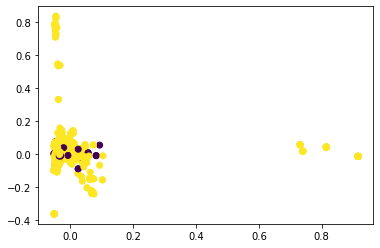

In [125]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
data = df[['final','SUSPICIOUS']]
original = data[data['SUSPICIOUS']!=-1]
k_means_params =  {'n_clusters':2}
# pipelines
kmeans_pipeline = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer()),
    ('clf',KMeans(**k_means_params))
])
vectorizer = Pipeline([
    ('vect',CountVectorizer(**vectorizer_params)),
    ('tfidf',TfidfTransformer())])
X = vectorizer.fit_transform(original['final']).todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=original.SUSPICIOUS)
plt.show()   

In [126]:
k = kmeans_pipeline.fit_predict(original['final'])

In [127]:
k

array([1, 1, 1, ..., 1, 1, 1])

- apply prediction the the unlabeled data 
- join to dataset where you applied prediction to the data
- test to see how accurate the labels are to each other 